In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
pred_dict = {}

In [4]:
with open('experiments/auth/conv/independent.pkl', 'rb') as f:
    pred_dict['independent'] = pickle.load(f)

In [5]:
with open('experiments/auth/conv_25/multidimensional.pkl', 'rb') as f:
    pred_dict['multidimensional'] = pickle.load(f)

In [6]:
with open('experiments/auth/conv_25/mixture.pkl', 'rb') as f:
    pred_dict['mixture'] = pickle.load(f)

In [7]:
def calculate_metric_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    tmp_metric_dict = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = [y_pred[i] for i in idx]
        y_true_sample = [y_true[i] for i in idx]
        tmp_metric_dict['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        tmp_metric_dict['precision'].append(precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['recall'].append(recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        tmp_metric_dict['f1'].append(f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))

    ret_metric_dict = {}
    for metric, metric_arr in tmp_metric_dict.items():
        ci_lower, ci_upper, mean = np.percentile(metric_arr, [2.5, 97.5, 50])
        ret_metric_dict[metric] = (mean, ci_lower, ci_upper)
    
    return ret_metric_dict

In [8]:
scores_arr = []
for method, method_dict in pred_dict.items():
    for votes_dict in method_dict:
        print(f'Calculating confidence interval for {method} with {votes_dict["votes"]} votes')
        y_pred = votes_dict['y_pred']
        y_true = votes_dict['y_true']
        tmp_dict = calculate_metric_confidence_interval(y_pred, y_true)
        tmp_dict['method'] = method
        tmp_dict['votes'] = votes_dict['votes']
        scores_arr.append(tmp_dict)

Calculating confidence interval for independent with 1 votes
Calculating confidence interval for independent with 3 votes
Calculating confidence interval for independent with 5 votes
Calculating confidence interval for independent with 10 votes
Calculating confidence interval for multidimensional with 1 votes
Calculating confidence interval for multidimensional with 3 votes
Calculating confidence interval for multidimensional with 5 votes
Calculating confidence interval for multidimensional with 10 votes
Calculating confidence interval for mixture with 1 votes
Calculating confidence interval for mixture with 3 votes
Calculating confidence interval for mixture with 5 votes
Calculating confidence interval for mixture with 10 votes


In [9]:
scores_arr

[{'accuracy': (0.222, 0.184, 0.256),
  'precision': (0.1648817520738703, 0.1378004822000916, 0.1919589023678362),
  'recall': (0.12443757852386035, 0.10509314861967302, 0.14788577983604345),
  'f1': (0.13193123573929882, 0.11208842599110283, 0.15464178167541232),
  'method': 'independent',
  'votes': 1},
 {'accuracy': (0.232, 0.196, 0.27),
  'precision': (0.17136653531469084, 0.14508319581958196, 0.19911253176353846),
  'recall': (0.14127110081802915, 0.12057354188272405, 0.1622250608638153),
  'f1': (0.14394065709660905, 0.12303835776875703, 0.1648616776644516),
  'method': 'independent',
  'votes': 3},
 {'accuracy': (0.266, 0.226, 0.306),
  'precision': (0.1965536195914326, 0.17167883042761595, 0.22352551447283275),
  'recall': (0.17128204406146452, 0.1505966453987917, 0.1922362017392855),
  'f1': (0.17230805608580427, 0.15189213906713875, 0.19376387698363745),
  'method': 'independent',
  'votes': 5},
 {'accuracy': (0.314, 0.27395, 0.356),
  'precision': (0.22754911530757396, 0.2040

In [13]:
def plot_metric_with_confidence_intervals(ax, scores_arr, metric, metric_label):

    # fig, ax = plt.subplots()
    idx_dict = {
        1: 0.5,
        3: 1.5,
        5: 2.5,
        10: 3.5,
    }
    color_dict = {
        'independent': 'tab:blue',
        'multidimensional': 'darkgoldenrod',
        'mixture': 'silver',
    }
    methods_in_legend = set()
    for s in scores_arr:
        mean = s[metric][0]
        ci_lower = s[metric][1]
        ci_upper = s[metric][2]
        y_idx = idx_dict[s['votes']]
        color = color_dict[s['method']]
        if s['method'] not in methods_in_legend:
            methods_in_legend.add(s['method'])
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, label=s['method'], color=color, height=0.25)
        else:
            ax.barh(y_idx, mean, xerr=[[mean - ci_lower], [ci_upper - mean]], capsize=3, color=color, height=0.25)
        idx_dict[s['votes']] += 0.25

    ax.set_yticks(np.arange(0.75, 4, 1))
    ax.set_yticklabels([1, 3, 5, 10])
    ax.set_xlabel(metric_label, fontsize=12)

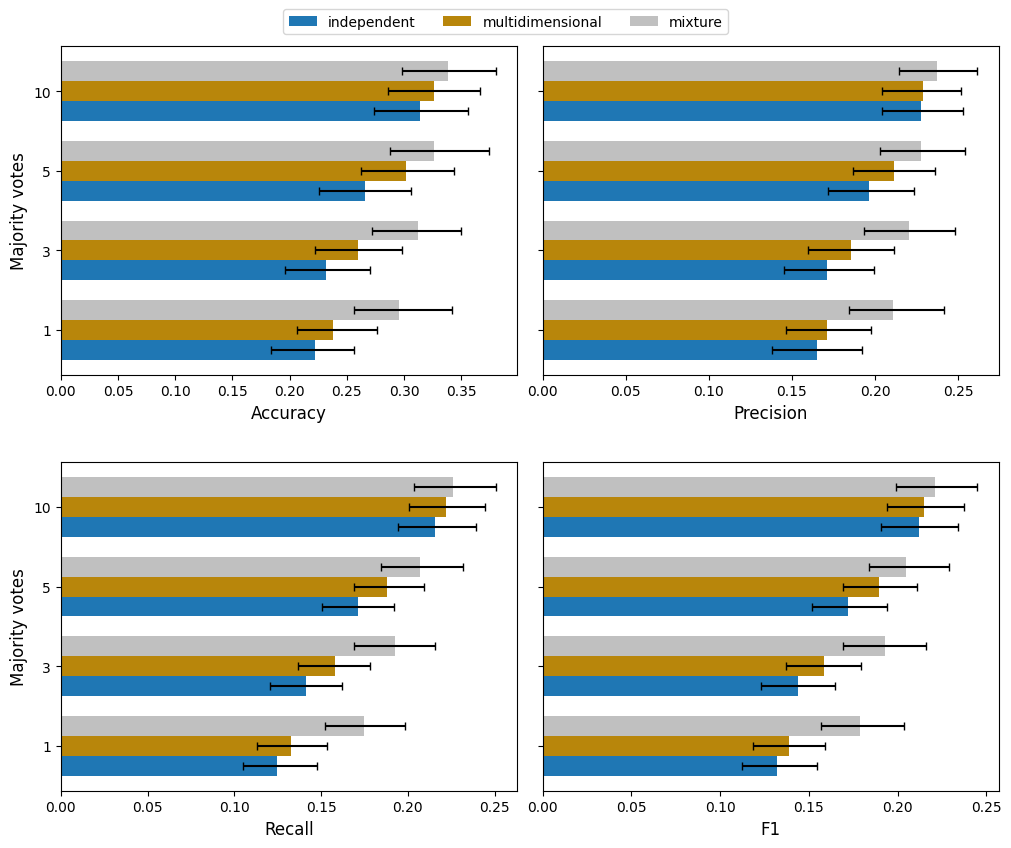

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True, sharey=True, gridspec_kw={'hspace': 0.1})
plot_metric_with_confidence_intervals(ax[0][0], scores_arr, 'accuracy', 'Accuracy')
plot_metric_with_confidence_intervals(ax[0][1], scores_arr, 'precision', 'Precision')
plot_metric_with_confidence_intervals(ax[1][0], scores_arr, 'recall', 'Recall')
plot_metric_with_confidence_intervals(ax[1][1], scores_arr, 'f1', 'F1')
ax[0,0].set_ylabel('Majority votes', fontsize=12)
ax[1,0].set_ylabel('Majority votes', fontsize=12)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig.savefig('figures/conv_relu/metrics.pdf', bbox_inches='tight')
plt.show()